In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

tesla = pd.read_csv('tesla_stocks.csv')
tesla.head()

,Date,Open,High,Low,Close,Volume
0,2-Aug-17,318.94,327.12,311.22,325.89,13091462
1,1-Aug-17,323.00,324.45,316.13,319.57,8303102
2,31-Jul-17,335.50,341.49,321.04,323.47,8535136
3,28-Jul-17,336.89,339.60,332.51,335.07,4880414
4,27-Jul-17,346.00,347.50,326.29,334.46,8302405


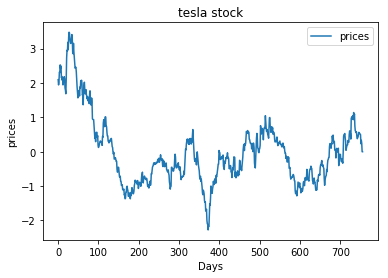

In [2]:
data = tesla['Close'].values
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.reshape(-1,1))
plt.figure(edgecolor='red')
plt.title('tesla stock')
plt.xlabel('Days')
plt.ylabel('prices')
plt.plot(scaled_data, label='prices')
plt.legend()
plt.show()

In [3]:
def train_data(data, input_size):
    X = []
    Y = []
    i = 0
    while (i + input_size) <= len(data) - 1:
        X.append(data[i:i+input_size])
        Y.append(data[i+input_size])
        i += 1
    assert len(X) == len(Y)
    return X,Y

X, Y = train_data(scaled_data, 7)
X[0],Y[0]

(array([[ 2.09666484],
        [ 1.94507542],
        [ 2.03861952],
        [ 2.31685325],
        [ 2.302222  ],
        [ 2.52744741],
        [ 2.42550832]]), array([ 2.49554647]))

In [ ]:
batch_size = 50
train, test = 0.8, 0.2
train_end = int(len(data)*0.8)
test_start = train_end
X_train = X[:train_end]
Y_train = Y[:train_end]
X_test= X[test_start:]
Y_test = Y[test_start:]
tf.reset_default_graph()
n_neurons = 512   #neurons that inside of each one time network
prob = 0.7        #dropout probability 30%
is_training = None    #training mode
number_layers = 5        #multiple RNN layers
#hidden_layer_number = 700
output_size = 1
input_size = 1
time_series = 7         #unrolled time
learning_rate = 0.001
X_ = tf.placeholder(tf.float32, shape=(None, time_series, input_size), name='X')
Y_ = tf.placeholder(tf.float32, shape=(None, output_size), name='Y')
batch = tf.placeholder(tf.int32, name='batch')
is_training = tf.placeholder(tf.bool, name="training_mode")
clip_threshold = 3    

with tf.name_scope('LSTM'):
    ###initializer stagery has been used
    layers = tf.contrib.rnn.OutputProjectionWrapper(
        tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons),output_size=1)
    #layers = [cell for layer in range(number_layers) ]
    
    ### dropout reduce the risk of overfitting
    #if is_training is not None:
       # layers = [tf.contrib.rnn.DropoutWrapper(layer, input_keep_prob=prob) for layer in layers]
    #stacked_layers = tf.contrib.rnn.MultiRNNCell(layers)
    #init_state = stacked_layers.zero_state(batch_size, tf.float32)
    outputs, states = tf.nn.dynamic_rnn(layers, X_, dtype=tf.float32)

with tf.name_scope('fc1'):
    #stacked_outputs = tf.reshape(outputs,[-1,n_neurons])
    #stacked_outputs.shape
    #stacked_output = stacked_outputs[-1]
    output_change = tf.reshape(outputs,(time_series, -1, 1))
    logits = output_change[-1]
    #hidden_1 = tf.layers.dense(n_neurons, hidden_layer_number, name='hidden', activation=tf.nn.relu)
    #logits = tf.layers.dense(last_output,output_size, name='logits', activation=None)
    #logits_outputs = tf.reshape(logits, [-1, time_series, output_size])

with tf.name_scope('train'):
    #loss = tf.losses.mean_squared_error(logits, Y_)
    
    loss = tf.reduce_mean(tf.square(logits-Y_))
    #loss = tf.reduce_sum(losses)/(2*batch_size)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    
    ###
    ###clip can reduce the gradient explore problem
    ###
    #grads_and_vars = optimizer.compute_gradients(loss)
    #capped_gvs = [(tf.clip_by_value(grad, -clip_threshold, clip_threshold), var) for grad, var in grads_and_vars]
    #training_op = optimizer.apply_gradients(capped_gvs)
    training_op = optimizer.minimize(loss)
  

In [117]:
#neurons that inside of each one time network
#dropout probability 30%
#training mode
#multiple RNN layers
#hidden_layer_number = 700
#unrolled time
class rnn(object):
    def __init__(self, data, X, Y, batch_size=1, n_neurons=512, prob = 0.7, is_training=False, number_layers=5, 
            output_size=1, input_size=1, time_series=7, learning_rate=0.001, clip_threshold=3):

        tf.reset_default_graph()
    
        self.X_ = tf.placeholder(tf.float32, shape=(None, time_series, input_size), name='X')
        self.Y_ = tf.placeholder(tf.float32, shape=(None, output_size), name='Y')
        X_ = self.X_
        Y_ = self.Y_
        with tf.name_scope('LSTM'):
            ###initializer stagery has been used
            #layers = self.layers
            layers = [tf.contrib.rnn.LSTMCell(initializer=tf.orthogonal_initializer, num_units=n_neurons) 
                  for layer in range(number_layers)]
            #self.layers = layers
            #layers = tf.contrib.rnn.OutputProjectionWrapper(
            #    tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons),output_size=1)
            #layers = [cell for layer in range(number_layers) ]

            ### dropout reduce the risk of overfitting
            if is_training:
                layers = [tf.contrib.rnn.DropoutWrapper(layer, input_keep_prob=prob) for layer in layers]
            stacked_layers = tf.contrib.rnn.MultiRNNCell(layers)
            #init_state = stacked_layers.zero_state(batch_size, tf.float32)
            outputs, states = tf.nn.dynamic_rnn(stacked_layers, X_, dtype=tf.float32)

        with tf.name_scope('fc1'):
            #stacked_outputs = tf.reshape(outputs,[-1,n_neurons])
            #stacked_outputs.shape
            #stacked_output = stacked_outputs[-1]
            output_change = tf.reshape(outputs,(time_series, -1, n_neurons))
            output_change = output_change[-1]
            logits = tf.layers.dense(output_change,output_size, name='logits', activation=None)
            #logits = output_change[-1]
            #hidden_1 = tf.layers.dense(n_neurons, hidden_layer_number, name='hidden', activation=tf.nn.relu)
            #logits = tf.layers.dense(last_output,output_size, name='logits', activation=None)
            #logits_outputs = tf.reshape(logits, [-1, time_series, output_size])

        with tf.name_scope('train'):
            #loss = tf.losses.mean_squared_error(logits, Y_)

            loss = tf.reduce_mean(tf.square(logits-Y_))
            #loss = tf.reduce_sum(losses)/(2*batch_size)
            optimizer = tf.train.AdamOptimizer(learning_rate)

            ###
            ###clip can reduce the gradient explore problem
            ###
            #grads_and_vars = optimizer.compute_gradients(loss)
            #capped_gvs = [(tf.clip_by_value(grad, -clip_threshold, clip_threshold), var) for grad, var in grads_and_vars]
            #training_op = optimizer.apply_gradients(capped_gvs)
            training_op = optimizer.minimize(loss)
            
        
        self.layers = layers
        self.stacked_layers = stacked_layers
        self.outputs = outputs
        self.states = states
        self.output_change = output_change
        self.logits = logits
        self.loss = loss
        self.training_op = training_op
        

In [118]:
rnn = rnn(data, X, Y, is_training=True)

In [41]:
rnn.is_training = True

Epoch 0/5  Current loss: 1.1897648572921753
Epoch 2/5  Current loss: 0.5536834597587585
Epoch 4/5  Current loss: 0.6814665198326111


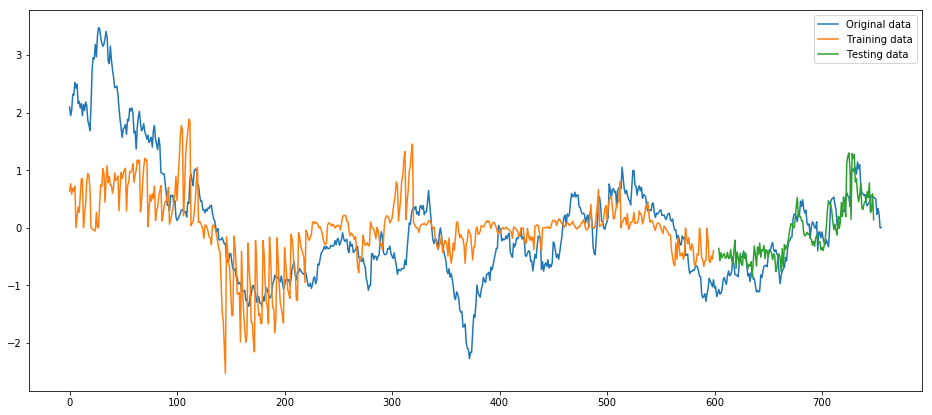

In [122]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
train, test = 0.8, 0.2
train_end = int(len(data)*0.8)
test_start = train_end
X_train = X[:train_end]
Y_train = Y[:train_end]
X_test= X[test_start:]
Y_test = Y[test_start:]
batch_size = 20
rnn.batch_size = batch_size  #set model batch size to 20
X_train = np.array(X_train)
X_train = X_train.reshape((-1,7,1))
Y_train = np.array(Y_train)
Y_train = Y_train.reshape((-1,1))
epochs = 5
best_loss = np.infty
max_tolerate = 60
with tf.Session() as sess:
    init.run()
    for epoch in range(epochs):
        traind_scores = []
        epoch_loss = []
        #print("restart:{}".format(len(traind_scores)))
        loop = 0
        while(loop+batch_size<=len(X_train)):  #mini-batch
        #for numbe in range(X_train.shape[0]):  #SGD
            #print(numbe)
            #X_batch = np.array(X)
            #X_batch = X_batch.reshape((-1,7,1))

            #Y_batch = np.array(Y)
            #Y_batch = Y_batch.reshape((-1,1))
            #X_fan = X_batch[numbe].reshape((-1,7,1))
           # Y_fan = Y_batch[numbe].reshape((-1,1))
            X_batch = X_train[loop:loop+batch_size]
            Y_batch = Y_train[loop:loop+batch_size]
            loop += batch_size
            #a, b, c, d,e = sess.run(
            #    [rnn.outputs, rnn.output_change, rnn.logits, rnn.loss, rnn.training_op, ], 
            #    feed_dict={rnn.X_:X_fan, rnn.Y_:Y_fan})
            c, d,e = sess.run(
                [ rnn.logits, rnn.loss, rnn.training_op ], 
               feed_dict={rnn.X_:X_batch, rnn.Y_:Y_batch})
            epoch_loss.append(d)
            traind_scores.append(c)
                #print("after append:{}".format(len(traind_scores)))
                #print(c)
                #print(traind_scores)

        if (epoch % 2) == 0:
            print('Epoch {}/{}'.format(epoch, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
    sup =[]
    for i in range(len(traind_scores)):
        for j in range(len(traind_scores[i])):
                    #print()
            sup.append(traind_scores[i][j])
                    #print(i,j)
    tests = []
    diao = 0
    rnn.is_training = False
    while diao+1 <= len(X_test):
        o = sess.run(rnn.logits, feed_dict={rnn.X_:X_test[diao:diao+1]})
        diao += 1
        tests.append(o)
    tests_new = []
    for i in range(len(tests)):
        for j in range(len(tests[i][0])):
            tests_new.append(tests[i][0][j])
    test_results = []
    for i in range(749):
        if i >= 604:
            test_results.append(tests_new[i-604])
        else:
            test_results.append(None)   
       
    plt.figure(figsize=(16, 7))
    plt.plot(scaled_data, label='Original data')
    plt.plot(sup, label='Training data')
    plt.plot(test_results, label='Testing data')
    plt.legend()
    plt.show()
    

In [70]:
with tf.Session() as sess:
    tests = []
    diao = 0
    rnn.is_training = False
    while diao+1 <= len(X_test):
        o = sess.run(rnn.logits, feed_dict={rnn.X_:X_test[diao:diao+1]})
        diao += 1
        tests.append(o)
    tests_new = []
    for i in range(len(tests)):
        for j in range(len(tests[i][0])):
            tests_new.append(tests[i][0][j])
    test_results = []
    for i in range(749):
        if i >= 604:
            test_results.append(tests_new[i-604])
        else:
            test_results.append(None)   

FailedPreconditionError: Attempting to use uninitialized value rnn/multi_rnn_cell/cell_2/lstm_cell/bias
	 [[Node: rnn/multi_rnn_cell/cell_2/lstm_cell/bias/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](rnn/multi_rnn_cell/cell_2/lstm_cell/bias)]]

Caused by op 'rnn/multi_rnn_cell/cell_2/lstm_cell/bias/read', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-7d17efb8332d>", line 1, in <module>
    rnn = rnn(data, X, Y, is_training=True)
  File "<ipython-input-35-decbbc6c2979>", line 30, in __init__
    outputs, states = tf.nn.dynamic_rnn(stacked_layers, X_, dtype=tf.float32)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn.py", line 614, in dynamic_rnn
    dtype=dtype)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn.py", line 777, in _dynamic_rnn_loop
    swap_memory=swap_memory)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2816, in while_loop
    result = loop_context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2640, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2590, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn.py", line 762, in _time_step
    (output, new_state) = call_cell()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn.py", line 748, in <lambda>
    call_cell = lambda: cell(input_t, state)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 183, in __call__
    return super(RNNCell, self).__call__(inputs, state)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 575, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 1066, in call
    cur_inp, new_state = cell(cur_inp, cur_state)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 891, in __call__
    output, new_state = self._cell(inputs, state, scope)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 183, in __call__
    return super(RNNCell, self).__call__(inputs, state)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 575, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 608, in call
    self._linear1 = _Linear([inputs, m_prev], 4 * self._num_units, True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 1180, in __init__
    initializer=bias_initializer)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1203, in get_variable
    constraint=constraint)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1092, in get_variable
    constraint=constraint)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 417, in get_variable
    return custom_getter(**custom_getter_kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1583, in wrapped_custom_getter
    *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 186, in _rnn_get_variable
    variable = getter(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 186, in _rnn_get_variable
    variable = getter(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 394, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 805, in _get_single_variable
    constraint=constraint)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 213, in __init__
    constraint=constraint)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 353, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 2070, in identity
    "Identity", input=input, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value rnn/multi_rnn_cell/cell_2/lstm_cell/bias
	 [[Node: rnn/multi_rnn_cell/cell_2/lstm_cell/bias/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](rnn/multi_rnn_cell/cell_2/lstm_cell/bias)]]


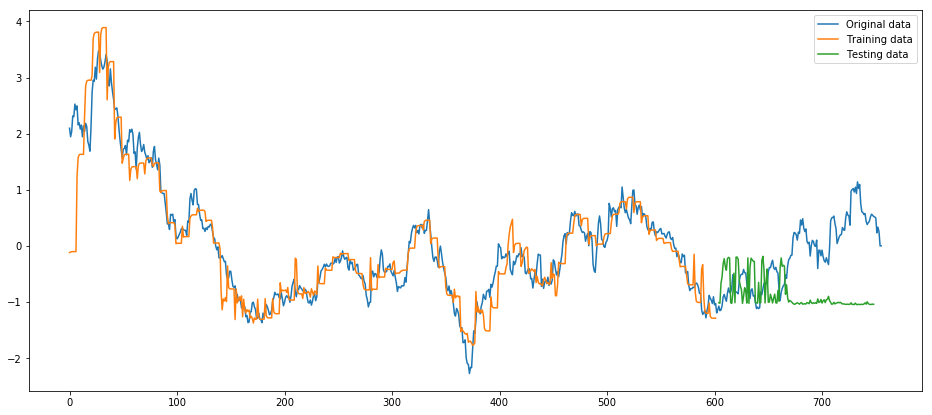

In [69]:
test_results = []
for i in range(749):
        if i >= 604:
            test_results.append(tests_new[i-604])
        else:
            test_results.append(None)       
plt.figure(figsize=(16, 7))
plt.plot(scaled_data, label='Original data')
plt.plot(sup1, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()

In [68]:
sup1 =[]
for i in range(len(traind_scores)):
    if i % 7 == 6:
        for j in range(len(traind_scores[i])):
                #print()
            sup1.append(traind_scores[i][j][0])
            print(traind_scores[i][j][0])

[-0.11867028]
[-0.10909262]
[-0.1030715]
[-0.1019732]
[-0.1014651]
[-0.10128494]
[-0.10124337]
[ 1.24139965]
[ 1.5731492]
[ 1.62421286]
[ 1.63211715]
[ 1.63220918]
[ 1.63275015]
[ 1.63161242]
[ 2.31775284]
[ 2.84743547]
[ 2.93826413]
[ 2.95055509]
[ 2.95441794]
[ 2.95329738]
[ 2.95236135]
[ 3.03539968]
[ 3.6951263]
[ 3.78581047]
[ 3.80153656]
[ 3.80937338]
[ 3.8074708]
[ 3.80999756]
[ 3.09074736]
[ 3.76323295]
[ 3.87296081]
[ 3.88813162]
[ 3.89029455]
[ 3.8906374]
[ 3.890661]
[ 2.60312629]
[ 3.17706847]
[ 3.26996493]
[ 3.28325987]
[ 3.28434086]
[ 3.28515744]
[ 3.28485489]
[ 1.90430343]
[ 2.19377375]
[ 2.28044367]
[ 2.29261518]
[ 2.29437184]
[ 2.29449987]
[ 2.29470205]
[ 1.47428286]
[ 1.56364477]
[ 1.62414348]
[ 1.63297975]
[ 1.63398504]
[ 1.6341964]
[ 1.63411307]
[ 1.16619992]
[ 1.36369908]
[ 1.40592802]
[ 1.41187489]
[ 1.41266716]
[ 1.41283989]
[ 1.4128387]
[ 1.19648659]
[ 1.42590761]
[ 1.46974003]
[ 1.47566259]
[ 1.47651982]
[ 1.47674096]
[ 1.47684884]
[ 1.28201723]
[ 1.51412904]
[ 1

In [82]:
sup =[]
for i in range(len(traind_scores)):
    #print(traind_scores[1])
    for j in range(len(traind_scores[i])):
            
        sup.append(traind_scores[i][j])
traind_scores[0]

array([[[-0.7479797 ]],

       [[-1.13888872]],

       [[-1.19289029]],

       [[-1.20106304]],

       [[-1.20215619]],

       [[-1.20229352]],

       [[-1.20230377]]], dtype=float32)